#### Importing libraries and defining functions

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def LF_step(q,p,a,dt,i,**kwargs):
    q_mid = q[i] + p[i]*dt/2
    p[i+1] = p[i] + a(q_mid,**kwargs)*dt
    q[i+1] = q_mid + p[i+1]*dt/2

def LFTT_step(W,t,q,p,a,dt,i,**kwargs):
    q_mid = q[i] + p[i]*(dt/2)/W[i]
    t_mid = t[i] + (dt/2)/W[i]
    q_mid_mag = np.linalg.norm(q_mid)
    p[i+1] = p[i] + a(q_mid,**kwargs)*dt*q_mid_mag
    W[i+1] = W[i] - np.dot(q_mid, ((p[i+1] + p[i])/2))*dt*(q_mid_mag**-2)
    q[i+1] = q_mid + p[i+1]*(dt/2)/W[i+1]
    t[i+1] = t_mid + (dt/2)/W[i+1]


GM_s = 4*(np.pi**2) # the GM values for sun in AU^3 year^-2
plt.rcParams['ytick.labelsize'] = 8


def gravity(r,GM=GM_s,delta=0,lamb=0):
    if lamb == 0: return - GM*r/(np.linalg.norm(r)**(3+delta))
    else: 
        r_mag = np.linalg.norm(r)
        return -GM*r*(r_mag**-(3+delta) + lamb*r_mag**-(5+delta))

def Orbit(
    GM=GM_s,
    r_init=np.array([1.017, 0.0]),
    v_init=np.array([0.0,6.179]),
    methods = {"LF":0.001},
    deltas =[0],
    lambs = [0],
    T_max = 5, # years
    a = gravity,
    vis=False,vis_prec=False
    ):
    if vis:
        fig = plt.figure(figsize=(10,20))
        AX = fig.subplots(15,1,sharex=True)
        fig2 = plt.figure()
        AX2 = fig2.subplots(1,1)
    if vis_prec:
        fig3 = plt.figure()
        AX3 = fig3.subplots(1,1)
    colors = ["blue","red","green","black","purple","yellow","brown"][::-1]

    precession_phi = {}
    precession_phi_regression = {}
    precession_phi_regression_R2 = {}
    precession_theta_r_min = {}
    precession_theta_r_min_regression = {}
    precession_theta_r_min_regression_R2 = {}
    for delta in deltas:
        for method, dt in methods.items():
            for lamb in lambs:
                if vis or vis_prec: c = colors.pop()
                t = np.arange(0,T_max+dt/2,dt)
                r = np.zeros((t.shape[0],2))
                v = np.zeros((t.shape[0],2))
                r[0] = r_init
                v[0] = v_init
                if method=="LF":
                    for i in range(t.shape[0]-1):
                        LF_step(r,v,gravity,dt,i,lamb=lamb,delta=delta)
                elif method=="LFTT":
                    W = np.zeros_like(t)
                    W[0] = 1/np.linalg.norm(r_init)
                    for i in range(t.shape[0]-1):
                        LFTT_step(W,t,r,v,gravity,dt,i,lamb=lamb,delta=delta)
                else: raise ValueError(f"unknown method: {method}")
                x = r[:,0]
                y = r[:,1]
                v_x = v[:,0]
                v_y = v[:,1]
                theta = np.arctan2(y,x)
                theta = theta + 2*np.pi*(theta <  0)
                r = (x**2 + y**2)**0.5
                v = (v_x**2 + v_y**2)**0.5
                E = 0.5*v**2 - GM/(r*(1+delta))
                L = x*v_y - y*v_x
                A_x,A_y = [L*v_y -GM*x/r,-L*v_x -GM*y/r]
                A = (A_x**2 + A_y**2)**0.5
                phi = np.arctan2(A_y,A_x)
                phi = 2*np.pi*(phi < 0) + phi
                v_r = (x*v_x + y*v_y)/r
                v_theta = (-y*v_x + x*v_y)/r
                omega = v_theta/r
                a = ((2/r) - ((v**2)/GM))**-1
                T = 2*np.pi*((a**3)/GM)**0.5 
                r_prev = np.concatenate((r[:1],r[:-1]))
                r_next = np.concatenate((r[1:],r[-1:]-1e-12))
                i_r = np.flatnonzero((r < r_prev) & (r <= r_next))
                theta_prev = np.concatenate((theta[:1],theta[:-1]))
                theta_next = np.concatenate((theta[1:],theta[-1:]))
                i_theta = np.flatnonzero((theta < theta_prev) & (theta <= theta_next))
                n_r = np.zeros_like(t,dtype=int)
                for i in i_r :
                    n_r = n_r + (np.arange(t.shape[0]) >= i)
                n_theta = np.zeros_like(t,dtype=int)
                for i in i_theta :
                    n_theta = n_theta + (np.arange(t.shape[0]) >= i)
                # n_theta = n_theta + theta/(2*np.pi)
                cond = (
                    f"({method}, " +
                    r"$\delta={" + str(delta)+ 
                    r"}$, $\Delta t=" + str(dt) + 
                    r"$, $\lambda=" + str(lamb)+"$)")

                precession_theta_r_min[cond] = (theta[i_r][-1]-theta[i_r][0])/(t[i_r][-1]-t[i_r][0])
                precession_phi[cond] = (phi[-1]-phi[0])/(t[-1]-t[0])

                X = np.vstack((n_theta[i_r],np.ones_like(n_theta[i_r]))).T

                param,res,rk,s = np.linalg.lstsq(X,theta[i_r],rcond=None)
                pred = np.dot(X,param)
                R2 = 1- (res[0]/X.shape[0])/(theta[i_r].var())

                param_phi,res,rk,s = np.linalg.lstsq(X,phi[i_r],rcond=None)
                pred_phi = np.dot(X,param_phi)
                R2_phi = 1- (res[0]/X.shape[0])/(phi[i_r].var())

                if vis_prec:
                    AX3.plot(n_theta[i_r],theta[i_r],'o',label=r"$\theta_{r_{min}}$ " + cond, color=c)
                    AX3.plot(n_theta[i_r],phi[i_r],'*',label=r"$\phi$ " + cond, color=c)
                    AX3.plot(n_theta[i_r],pred,":",label=r"fitted line for $\theta_{r_{min}}$ " + cond, color=c)
                    AX3.plot(n_theta[i_r],pred_phi,"-",label=r"fitted line for $\phi$ " + cond, color=c)
                
                precession_theta_r_min_regression[cond] = param[0]
                precession_theta_r_min_regression_R2[cond] = R2
                precession_phi_regression[cond] = param_phi[0]
                precession_phi_regression_R2[cond] = R2_phi

                if not vis:continue
                AX[0].plot(t,v_x,label=cond,color=c) 
                AX[1].plot(t,v_y,label=cond,color=c)
                AX[2].plot(t,theta,label=cond,color=c)
                AX[2].plot(t[i_theta],theta[i_theta],'o',label="minima " + cond,color=c)
                AX[3].plot(t,r,label=cond,color=c)
                AX[3].plot(t[i_r],r[i_r],'o',label="minima " + cond,color=c)
                AX[4].plot(t,v,label=cond,color=c)
                AX[5].plot(t,v_r,label=cond,color=c)
                AX[6].plot(t,omega,label=cond,color=c)
                AX[7].plot(t,n_r,label=cond,color=c)
                AX[8].plot(t,n_theta,label=cond,color=c)
                AX[9].plot(t,E,label=cond,color=c)
                AX[10].plot(t,L,label=cond,color=c)
                AX[11].plot(t,A,label=cond,color=c)
                AX[12].plot(t,phi,label=cond,color=c)
                AX[13].plot(t[i_r],theta[i_r],'-o',label=cond)
                AX[14].plot(t[i_theta+1], (n_r[i_theta+1]/n_theta[i_theta+1]),'-o',label=cond)

                AX2.plot(x,y,label=cond,color=c)
                AX2.plot(x[0],y[0],'o',label="initial position" + cond,color=c)

    if vis:
        AX[2].set_ylim(0,2*np.pi)
        AX[2].set_yticks([0,2*np.pi],[0,r"$2\pi$"])
        AX[2].legend()
        AX[7].legend()
        AX[8].legend()
        AX[12].set_ylim(0,2*np.pi)
        AX[12].set_yticks([0,2*np.pi],[0,r"$2\pi$"])
        AX[13].set_ylim(0,2*np.pi)
        AX[13].set_yticks([0,2*np.pi],[0,r"$2\pi$"])
        ylabels = ["v_x","v_y",r"\theta","r","v","v_r",r"\omega",r"n_r",r"n_\theta",r"E/m",r"L/m",r"A/m^2",r"\phi",
        r"\theta_{r_{min}}",r"n_r/n_\theta"]
        for ax,lbl in zip(AX,ylabels): 
            ax.set_ylabel("$" + lbl + "$")
            # ax.legend()

        # AX[12].set_xlabel("$t$ (years)")
        AX[12].legend()
        AX[13].legend()
        AX[14].legend()
        AX[14].set_xlabel(r"$t$ (years)")

        AX2.set_xlabel("$x$ (AU)")
        AX2.set_ylabel("$y$ (AU)")
        AX2.plot([0],[0],'o',label="sun",color="yellow",markersize=10)
        AX2.axhline(0)
        AX2.axvline(0)
        AX2.set_aspect('equal')
        AX2.set_xlim(-0.1-np.linalg.norm(r_init),0.1+2*np.linalg.norm(r_init))
        AX2.set_ylim(-0.1-np.linalg.norm(r_init),0.1+2*np.linalg.norm(r_init))
        AX2.legend()
    
    if vis_prec:
        AX3.legend()
        AX3.set_xlabel(r"$n_\theta$")
        AX3.set_ylabel(r"$\theta_p$")

    return (
        precession_theta_r_min,
        precession_theta_r_min_regression,
        precession_theta_r_min_regression_R2,
        precession_phi,
        precession_phi_regression,
        precession_phi_regression_R2
        )


## Mini-Project 1 : Closed and Open Orbits in Modified Gravity

### Parts 1 and 2: Earth-Sun system with standard LF

For a given accelleration $\vec a(\vec q)$, the position-verlet LF integrator does :

$$
\vec q_{t+\Delta t/2} = \vec q_{t} + \vec p_t \Delta t/2 \\
\vec p_{t+\Delta t} = \vec p_{t} + \vec a(\vec q_{t+\Delta t/2})\Delta t\\
\vec q_{t} = \vec q_{t+\Delta t/2} + \vec p_{t+\Delta t} \Delta t/2 
$$

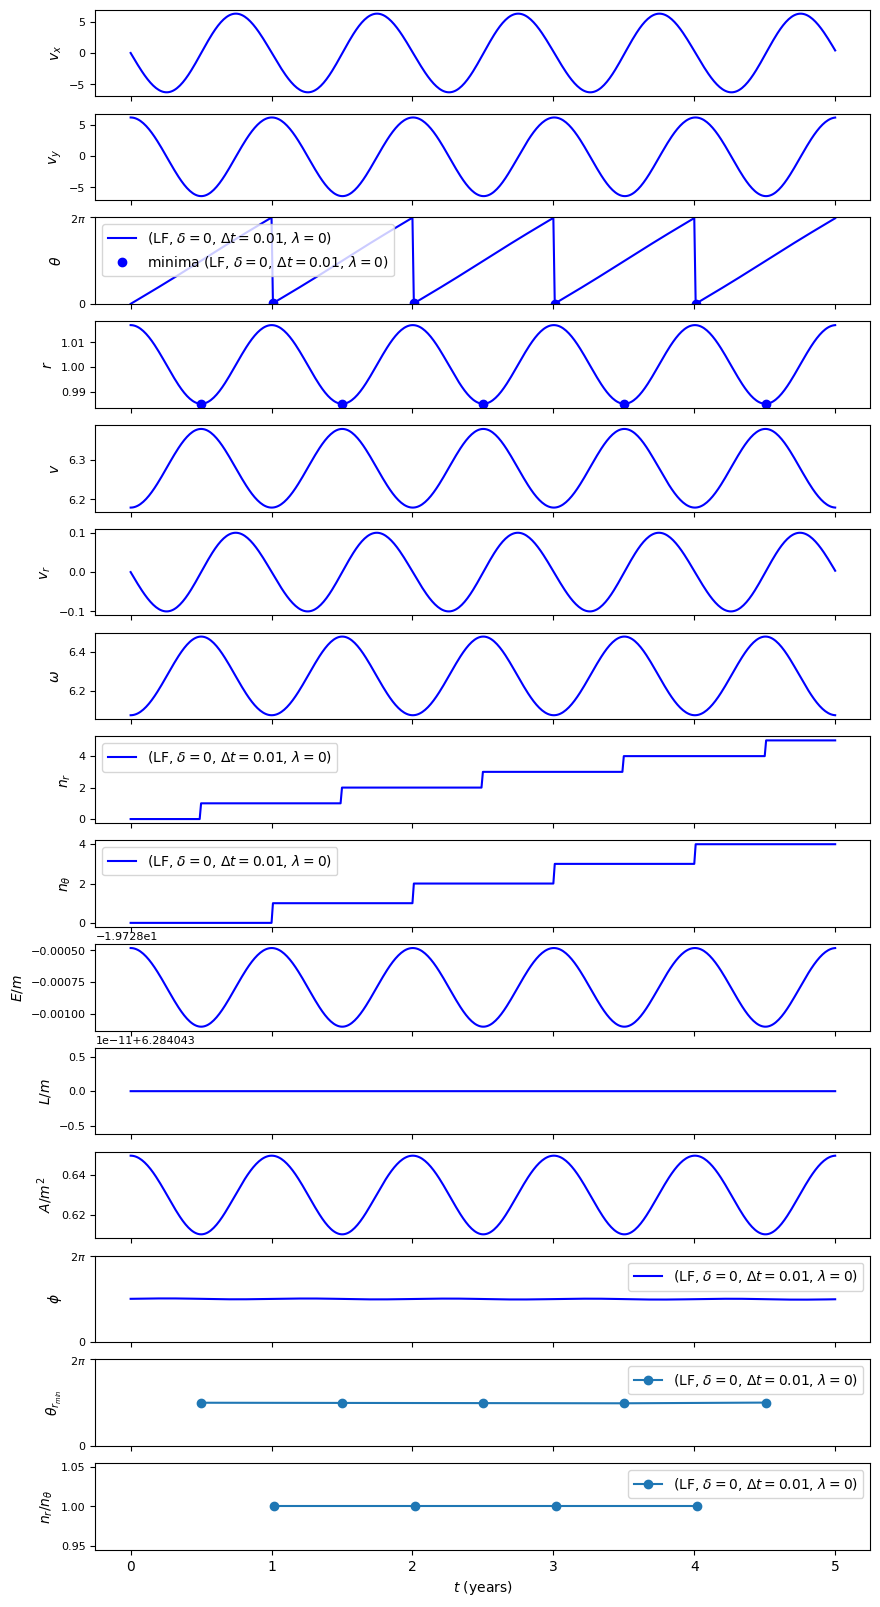

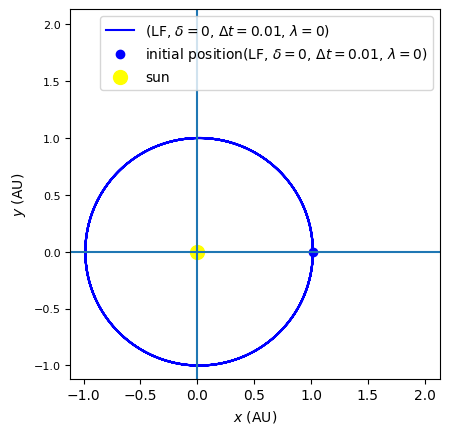

In [28]:
Orbit(vis=True,T_max=5,deltas=[0],methods={"LF":0.01},
    r_init=np.array([1.017, 0.0]), # AU
    v_init=np.array([0.0,6.179]) # AU/year
)
plt.show()

### Parts 3 and 4 : Closed Orbits

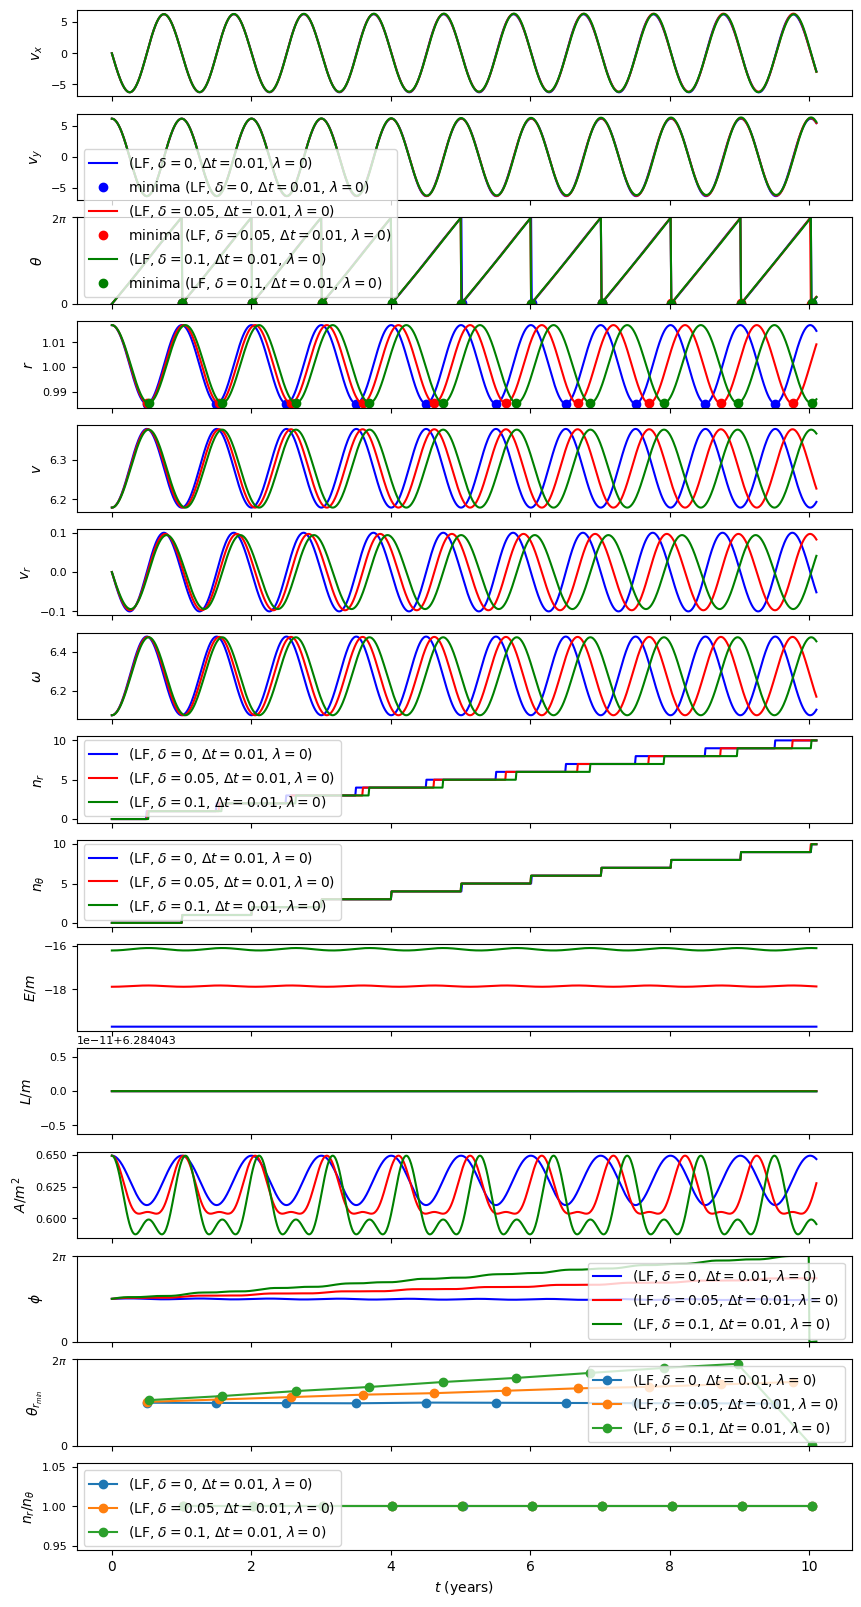

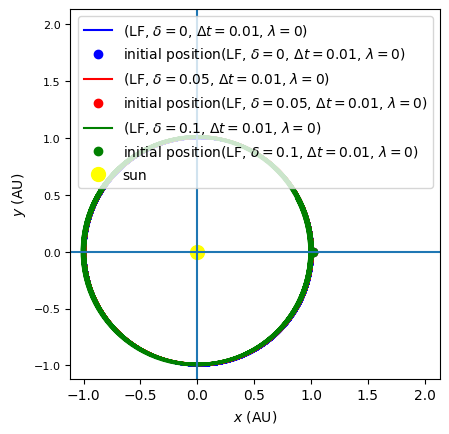

In [29]:
Orbit(vis=True,T_max=10.1,deltas=[0,0.05,0.1],methods={"LF":0.01},
    r_init=np.array([1.017, 0.0]), # AU
    v_init=np.array([0.0,6.179]) # AU/year
)
plt.show()

Defining perihelion for a single revolution as the point where the minimum distance from the sun is reached, we can now see how the angle $\theta_{r_\text{min}}$ that this point lies on (reltive to x-axis) changes with revolutions/time. 

This effect is not visible in the plot for trajectory because the trajectory isn't all that elliptic.

The same effect is also seen in the angle $\phi$ which is the angle where the Rung-Lenz vector points.

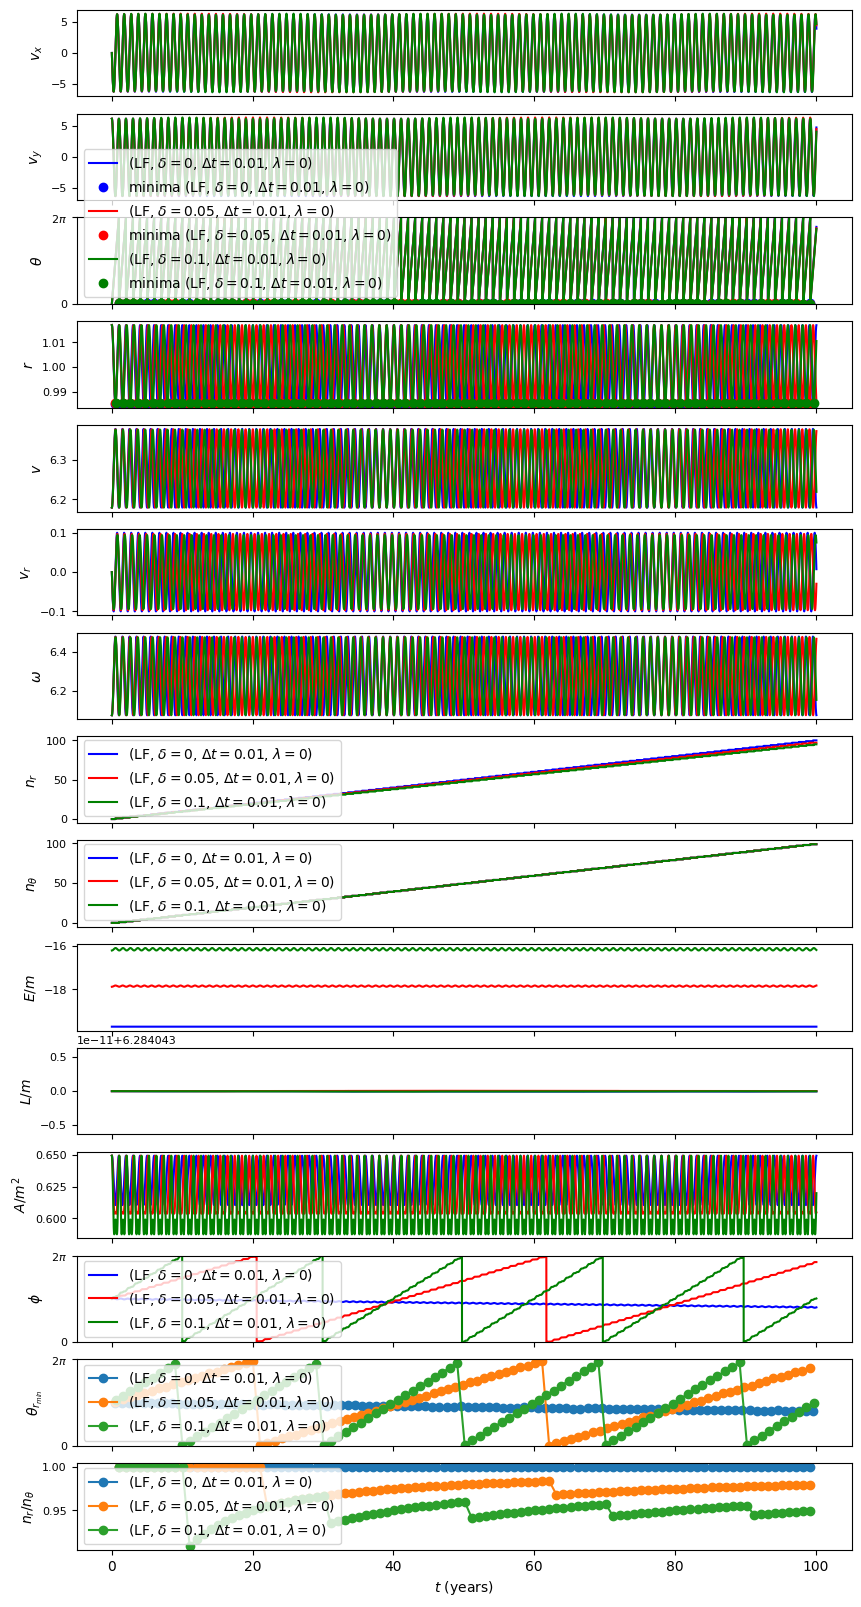

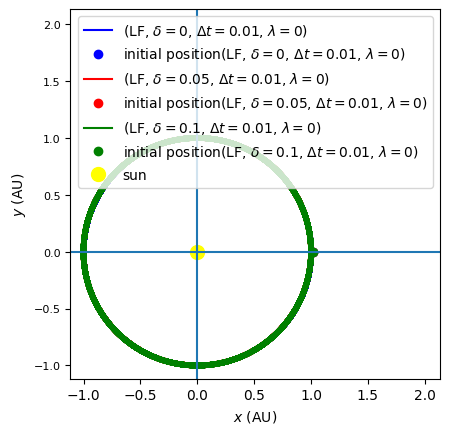

In [30]:
Orbit(vis=True,T_max=100.1,deltas=[0,0.05,0.1],methods={"LF":0.01},
    r_init=np.array([1.017, 0.0]), # AU
    v_init=np.array([0.0,6.179]) # AU/year
)
plt.show()

Take a look at the plot for $n_r/n_\theta$. You will see that the case with $\delta =0$ has no deviations, wherease others have very small (~0.05), but persistent deviation from the initial ratio of 1.

A "closed" orbit is defined as one which repeats itself over and over. Suppose during one fundamental period (of length $T_F$), we see $\Delta n_r$ new local minima for the distance $r$ and there are $\Delta n_\theta = (\Delta \theta)/(2\pi)$ revolutions (which is necessarily an integer for the position to be the same before and after the period) done by the body, and just before this period, at time $t_0$, there were $n_{r}(t_0)$ local minima in $r$ and $n_{\theta}(t_0)$ revolutions done, then it's easy to see that 

$$
n_r(t_0 + kT_F) = n_r(t_0) + k \Delta n_r \\
n_\theta(t_0 + kT_F) = n_\theta(t_0) + k \Delta n_\theta \\
\implies (\frac{n_r}{n_\theta})(t_0 + kT_F) = \frac{n_r(t_0) + k \Delta n_r}{n_\theta(t_0) + k \Delta n_\theta} 
$$

Now, since at $t=0$, our observation has just started, we have $n_r(0) = 0$. Similarly, one can _define_ $\theta(0) = 0$ by difinind the $t=0$ state as one where the body is on the x-axis (same as what we have set for the simulation). 

This gives us $n_\theta(0) = 0$. Then setting $t_0 = 0$, we simply get :

$$
(\frac{n_r}{n_\theta})(kT_F) = \frac{\Delta n_r}{\Delta n_\theta} 
$$

Even without all this, we still have :

$$
\lim_{k\to\infty}(\frac{n_r}{n_\theta})(t_0 + kT_F) = \lim_{k\to\infty}\frac{n_r(t_0) + k \Delta n_r}{n_\theta(t_0) + k \Delta n_\theta} = \frac{\Delta n_r}{\Delta n_\theta}
$$

As we saw in the plot, we also have convergence for the limit

$$
\lim_{t\to\infty}(\frac{n_r}{n_\theta})(t)
$$

This then lets us say that

$$
\lim_{t\to\infty}(\frac{n_r}{n_\theta})(t) = \lim_{k\to\infty}(\frac{n_r}{n_\theta})(t_0 + kT_F) = \frac{\Delta n_r}{\Delta n_\theta}
$$

Regardless of whether we use this limit or the $(\frac{n_r}{n_\theta})(kT_F)$ value with the correct setting ($\theta(0) = 0$), we can say that the value, which is $\frac{\Delta n_r}{\Delta n_\theta}$, is rational. This is so since $\Delta n_r$ is by definition an integer, and $\Delta n_\theta = \frac{\Delta \theta }{2\pi}$ also _needs_ to be an integer for the period $T_F$ to be a fundamental period. 

Thus we have proved that an orbit being periodic/closed implies that the ratio $n_r/n_\theta$ (with correct setting or under the $t\to\infty$ limit) is rational. 

The contrapositive is then that this ratio being irrational implies that the orbit is not closed/periodic.


Now, coming back to the results of the simulation; while we can say with certainty that the orbit with $\delta = 0$ is closed since we have $n_r/n_\theta = 1$ (a rational number), we cannot say anything about the other two cases. Since we don't know the $T_F$ for these cases (or even that these _are_ periodic; which they are not actually), we cannot compute the ratio at integer multiples of $T_F$. So instead, we must look at the limit as $t\to \infty$. While we may get a good estimate of the ratio by looking at very high $t$, we cannot know whether the result of the limit is rational or not. 

Thus, the only thing we _can_ do is evaluate the limit analytically. Effectively, we must find a way to count the number of local minima in $r(\theta)$ with the given $\delta$ and initial conditions. 

Since that is not part of this project, I will not do that.

Now, to simulate the hook's law, we will simply set $\delta := -3$

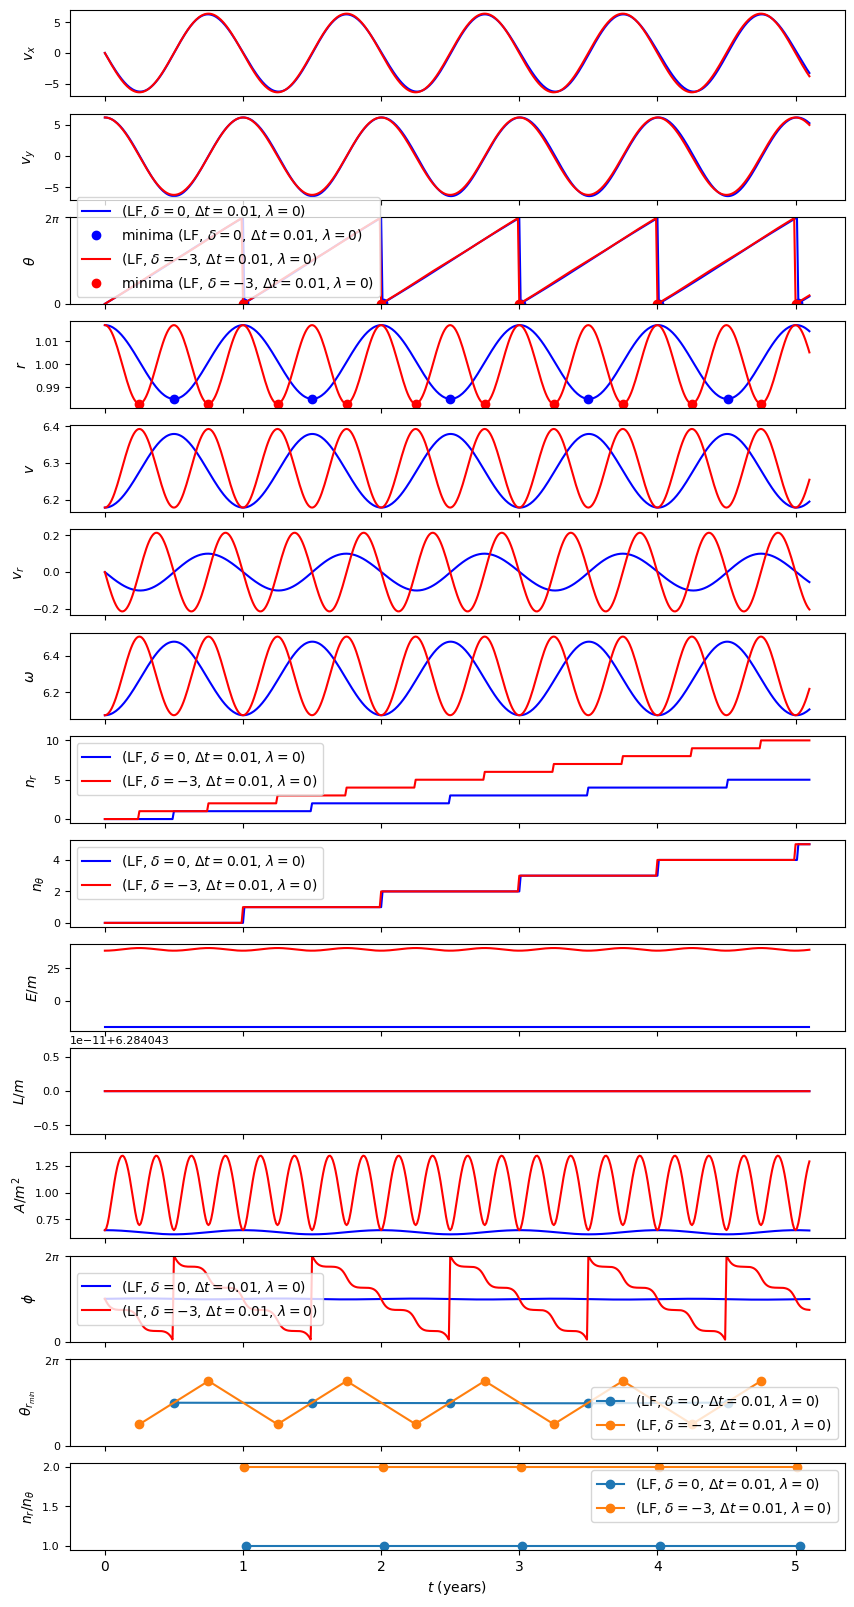

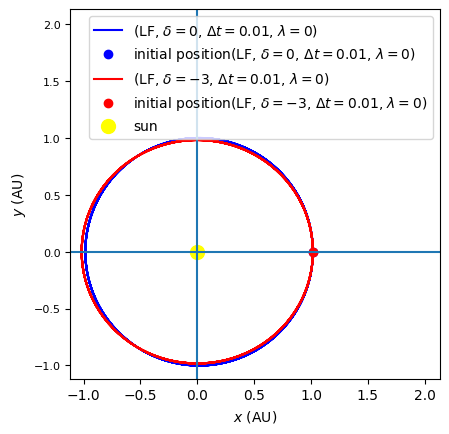

In [31]:
Orbit(vis=True,T_max=5.1,deltas=[0,-3],methods={"LF":0.01},
    r_init=np.array([1.017, 0.0]), # AU
    v_init=np.array([0.0,6.179]) # AU/year
)
plt.show()

Amazingly, the $\delta = -3$ case has its fundamental period for $\theta(t)$ match exactly with the $\delta =0$ case. 
On the other hand, the funadmental period of $r(t)$ is half that of the $\delta =0$ case. This give the consistent ratio of $n_r/n_\theta = 2$. 

Let's retry this with the initial conditions corresponding to mercury at its aphelion.

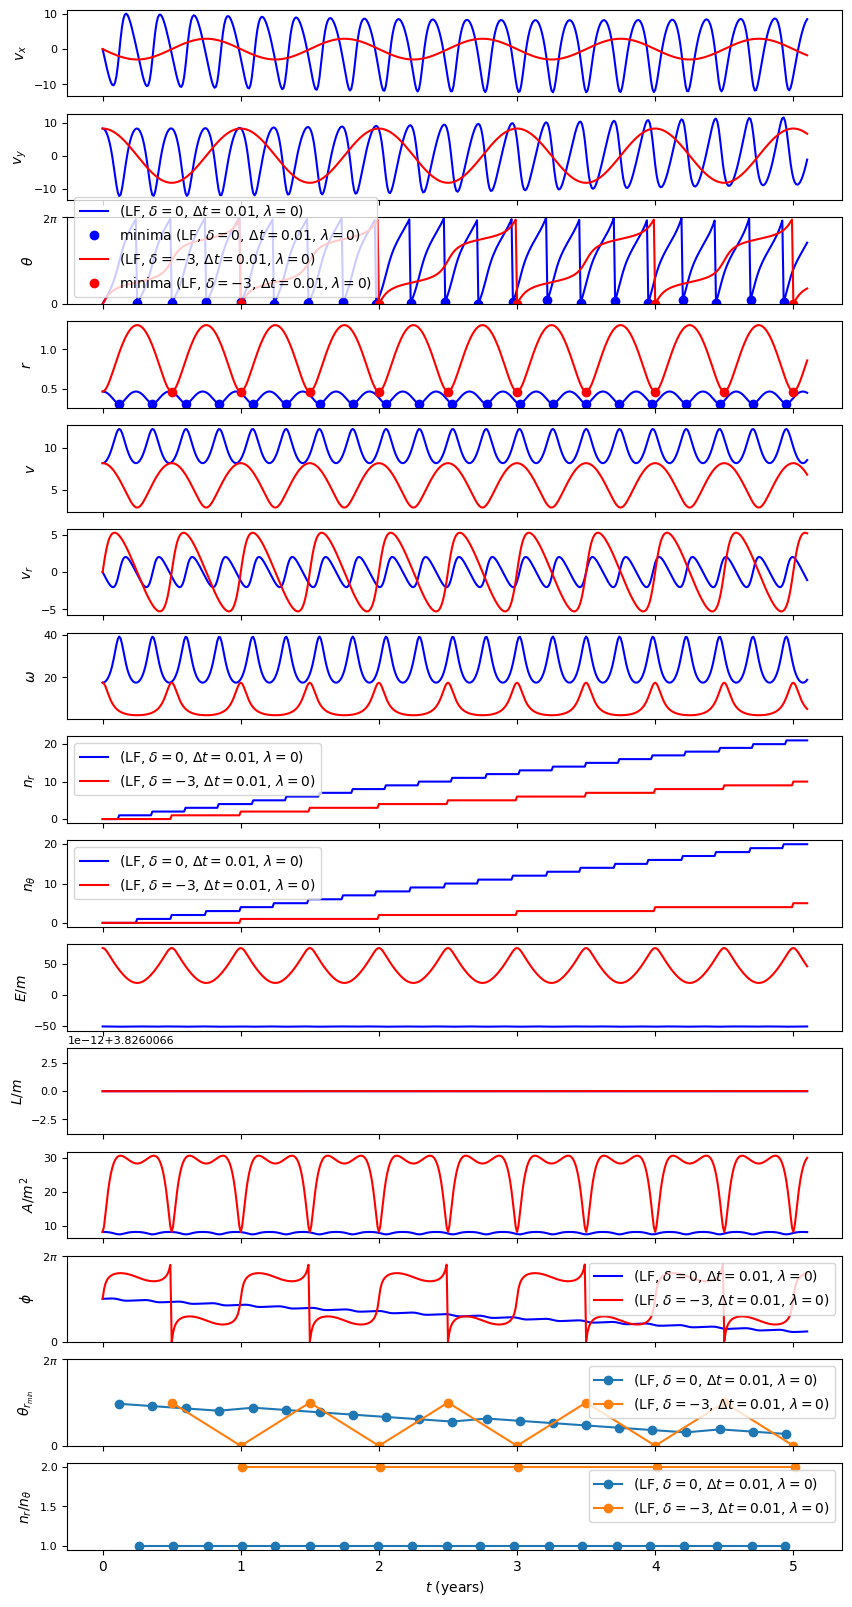

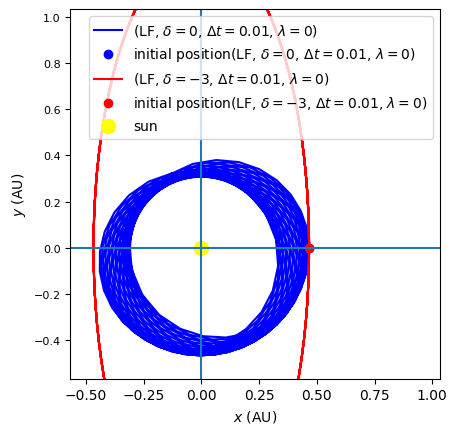

In [32]:
Orbit(vis=True,T_max=5.1,deltas=[0,-3],methods={"LF":0.01},
    r_init=np.array([0.4667, 0.0]), # AU
    v_init=np.array([0.0, 8.198]) # AU/year
)
plt.show()

Surprisingly, for Mercury, with a much more eliptic (real life) orbit, the $\delta =0$ case is the one that seems to appear "not closed" as the $\theta_{r_\text{min}}$ changes ever so slightly. This, I believe is due to the inadequacy of naive leapfrog integrator when dealing with high variation in velocities. To account for that, we shall use the time-transformed leap-frog integrator.

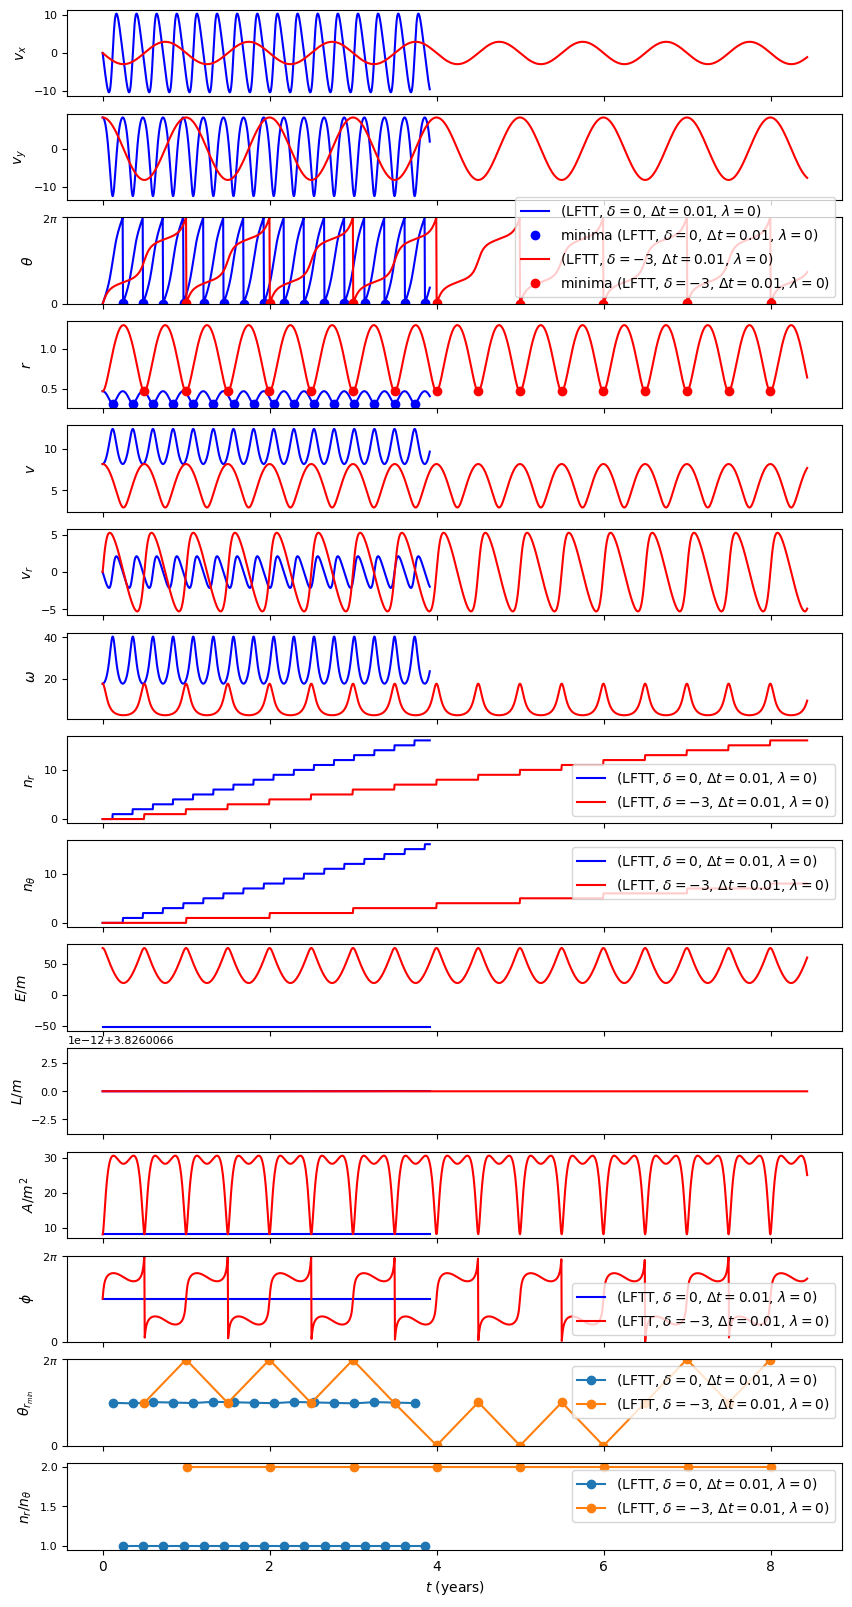

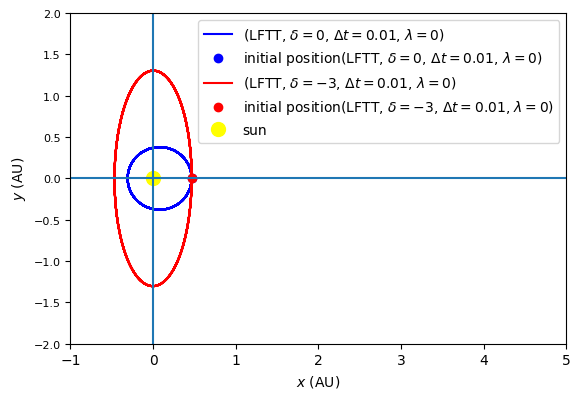

In [37]:
Orbit(vis=True,T_max=10.1,deltas=[0,-3],methods={"LFTT":0.01},
    r_init=np.array([0.4667, 0.0]), # AU
    v_init=np.array([0.0, 8.198]) # AU/year
)
plt.ylim(-2,2)
plt.xlim(-1,5)
plt.show()

As you can see, using the time-transformed leapfrog (LFTT) fixes the change in $\theta_{r_\text{min}}$, giving us the usual eliptic orbit for $\delta = 0$. 
Since LFTT uses a variable $s$ to parameterise the trajectory, which is different from $t$, thus the periods for which the simulation is done turn out to be different for different trajectories, even if the input intervals for $s$ are the same. 
This effect is visible in the images above as well. 

Even with the settings for Mercury, we see that $n_r/n_\theta$ stays at the value of 2 consistently. This proves that bounded orbits produced by forces following Hooke's law ($delta = -3$) and the inverse square law ($\delta = 0$) are closed.  
The potentials corresponding to these have $r^2$ and $1/r$ power laws. This is in-line with this analytic statement (from Chapter 4 of "Computational Modeling and Visualization of Physical Systems with Python") :

> As it turns out, of all the possible forces in the universe, only $1/r$ (gravitational and
Coulombic) and $r^2$ (harmonic, i.e., Hooke's law) potentials can produce closed orbits.

The lab sheet states "$1/r$ and $r$", which is most likely a typing error.


## Mini-Project 2

precession using angle at perihelion: 
(LFTT, $\delta={0}$, $\Delta t=0.01$, $\lambda=0$)  :  -0.0122  radians/year
(LFTT, $\delta={0}$, $\Delta t=0.01$, $\lambda=0.01$)  :  2.3787  radians/year
(LFTT, $\delta={0}$, $\Delta t=0.01$, $\lambda=1.1e-08$)  :  -0.0122  radians/year
precession using angle at perihelion with regression: 
(LFTT, $\delta={0}$, $\Delta t=0.01$, $\lambda=0$)  :  0.0032814110028277737 radians/revolution | R^2 :  0.022711362819226366
(LFTT, $\delta={0}$, $\Delta t=0.01$, $\lambda=0.01$)  :  0.5596736882840839 radians/revolution | R^2 :  0.9980627583653353
(LFTT, $\delta={0}$, $\Delta t=0.01$, $\lambda=1.1e-08$)  :  0.0032818183902121037 radians/revolution | R^2 :  0.022716868341551955
precession using Rung-Lenz vector direction: 
(LFTT, $\delta={0}$, $\Delta t=0.01$, $\lambda=0$)  :  -0.0  radians/year
(LFTT, $\delta={0}$, $\Delta t=0.01$, $\lambda=0.01$)  :  2.5838  radians/year
(LFTT, $\delta={0}$, $\Delta t=0.01$, $\lambda=1.1e-08$)  :  0.0  radians/year
precess

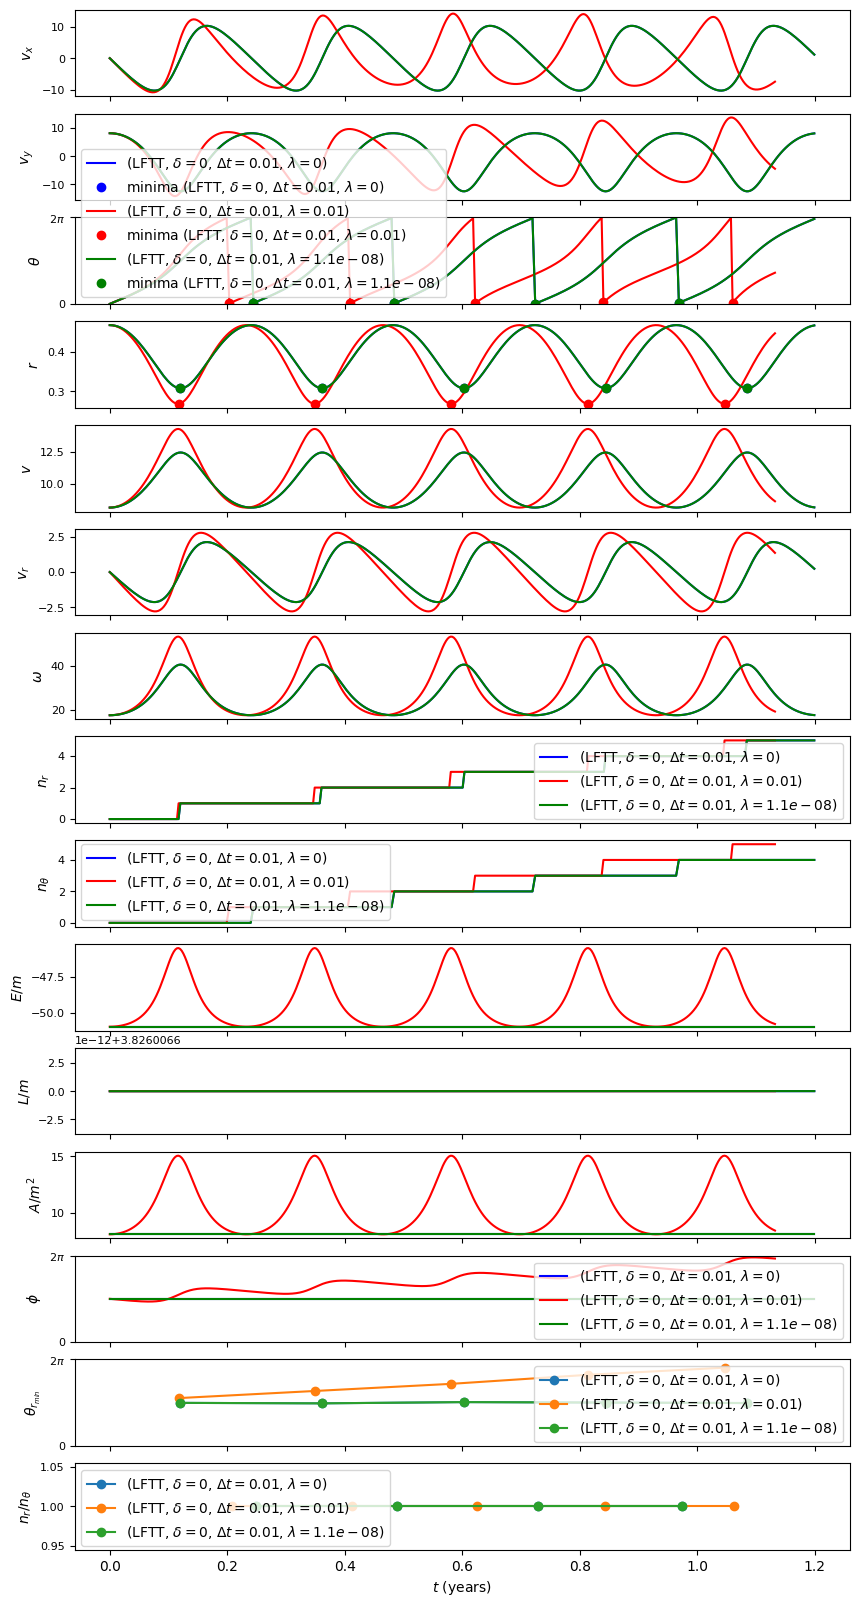

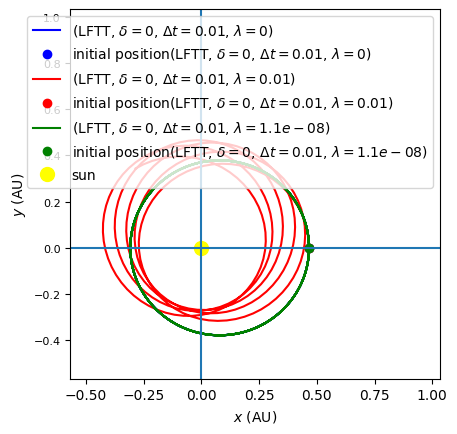

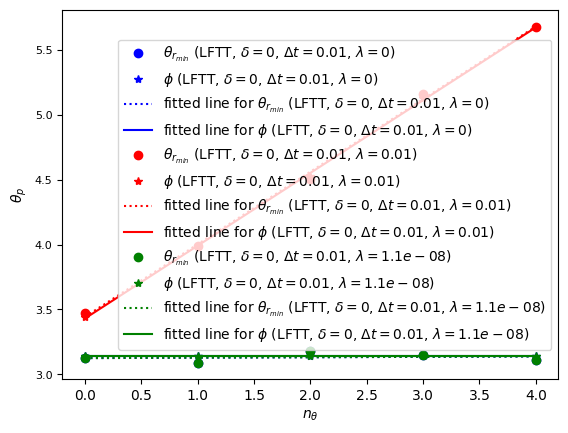

In [88]:
output = Orbit(
    vis=True,vis_prec=True,T_max=3.1,deltas=[0],lambs=[0,0.01,1.1e-8],methods={"LFTT":0.01},
    r_init=np.array([0.4667, 0.0]), # AU
    v_init=np.array([0.0, 8.198]) # AU/year
)
precession_theta_r_min = output[0]
precession_theta_r_min_regression = output[1]
precession_theta_r_min_regression_R2 = output[2]
precession_phi = output[3]
precession_phi_regression = output[4]
precession_phi_regression_R2 = output[5]
print("precession using angle at perihelion: ")
for x,y in precession_theta_r_min.items(): print(x," : ",round(y,4), " radians/year")
print("precession using angle at perihelion with regression: ")
for cond in precession_theta_r_min_regression: 
    print(cond," : ",
    precession_theta_r_min_regression[cond],
    "radians/revolution | R^2 : ",
    precession_theta_r_min_regression_R2[cond])
print("precession using Rung-Lenz vector direction: ")
for x,y in precession_phi.items(): print(x," : ",round(y,4), " radians/year")
print("precession using Rung-Lenz vector direction with regression: ")
for cond in precession_phi_regression: 
    print(cond," : ",
    precession_phi_regression[cond],
    "radians/revolution | R^2 : ",
    precession_phi_regression_R2[cond])
plt.show()

As you can see from the plot of the trajectory, the $\lambda=0.01$ case does not appear to be closed. Moreover, we see that the angles $\phi$ and $\theta_{r_\text{min}}$, both of which are estimates for the angle $\theta_p$ that gives the position of the periheliion, increase linearly with $n_\theta$. At $\lambda=0.01$, the goodness of fit ($R^2$) for linear regression of $\phi$ and $\theta_{r_\text{min}}$ on $n_\theta$ are around 0.9981 and 0.9997 respectively. This is clear evidence of the linear relationship. 

Also, for $\lambda = 1.1\times10^{-8}$, we see $R^2$ values of 0.0227 and 0.9994 when using $\theta_{r_\text{min}}$ and $\phi$ for data-points respectively.

The low goodness of fit for $\theta_{r_\text{min}}$ might be because the time-frame is too small.
Moving to slightly more than a century, we may see a higher $R^2$.

But first, I will do it for  ~10 years.

precession using angle at perihelion: 
(LFTT, $\delta={0}$, $\Delta t=0.001$, $\lambda=1.1e-08$)  :  -136.5878  arc-seconds/year
precession using angle at perihelion with regression: 
(LFTT, $\delta={0}$, $\Delta t=0.001$, $\lambda=1.1e-08$)  :  -9.577008486176128 arc-seconds/revolution | R^2 :  0.0018492469107205256
precession using Rung-Lenz vector direction: 
(LFTT, $\delta={0}$, $\Delta t=0.001$, $\lambda=1.1e-08$)  :  0.4071  arc-seconds/year
precession using Rung-Lenz vector direction with regression: 
(LFTT, $\delta={0}$, $\Delta t=0.001$, $\lambda=1.1e-08$)  :  0.10367929128421743 arc-seconds/revolution | R^2 :  0.9999985258208333


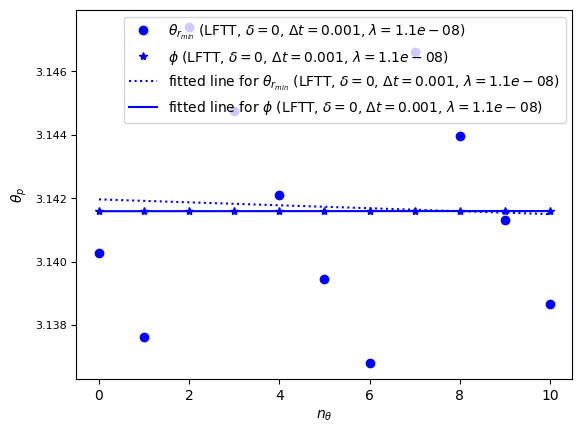

In [89]:
output = Orbit(
    vis=False,vis_prec=True,T_max=7.1,deltas=[0],lambs=[1.1e-8],methods={"LFTT":0.001},
    r_init=np.array([0.4667, 0.0]), # AU
    v_init=np.array([0.0, 8.198]) # AU/year
)
precession_theta_r_min = output[0]
precession_theta_r_min_regression = output[1]
precession_theta_r_min_regression_R2 = output[2]
precession_phi = output[3]
precession_phi_regression = output[4]
precession_phi_regression_R2 = output[5]
cf = 3600*180/np.pi
print("precession using angle at perihelion: ")
for x,y in precession_theta_r_min.items(): print(x," : ",round(cf*y,4), " arc-seconds/year")
print("precession using angle at perihelion with regression: ")
for cond in precession_theta_r_min_regression: 
    print(cond," : ",
    cf*precession_theta_r_min_regression[cond],
    "arc-seconds/revolution | R^2 : ",
    precession_theta_r_min_regression_R2[cond])
print("precession using Rung-Lenz vector direction: ")
for x,y in precession_phi.items(): print(x," : ",round(cf*y,4), " arc-seconds/year")
print("precession using Rung-Lenz vector direction with regression: ")
for cond in precession_phi_regression: 
    print(cond," : ",
    cf*precession_phi_regression[cond],
    "arc-seconds/revolution | R^2 : ",
    precession_phi_regression_R2[cond])
plt.show()

As you can see, there is a lot of noise in the estime $\theta_{r_\text{min}}$ for $\theta_p$. Compared to that, $\phi$ (Rung-Lenz vector direction) performs much better. 
The period of revolution for Mercury is around 88 days, or 0.241 years, the quantity from linear regression translates to around 0.43 arc-seconds per year. This is also what one expects to find.
In comparison, the $\theta_{r_{max}}$ estimate gives really poor results.

In [90]:
0.10367929128421743 / 0.241

0.4302045281502798

Now, we can do the same computation, but for more than a 1000 years. This should improve the accuracy.

precession using angle at perihelion: 
(LFTT, $\delta={0}$, $\Delta t=0.001$, $\lambda=1.1e-08$)  :  136.1009  arc-seconds/century
precession using angle at perihelion with regression: 
(LFTT, $\delta={0}$, $\Delta t=0.001$, $\lambda=1.1e-08$)  :  42.139729278695455 arc-seconds/century | R^2 :  0.0040305284999546664
precession using Rung-Lenz vector direction: 
(LFTT, $\delta={0}$, $\Delta t=0.001$, $\lambda=1.1e-08$)  :  43.0201  arc-seconds/century
precession using Rung-Lenz vector direction with regression: 
(LFTT, $\delta={0}$, $\Delta t=0.001$, $\lambda=1.1e-08$)  :  43.02272472398365 arc-seconds/century | R^2 :  0.9999999999241171


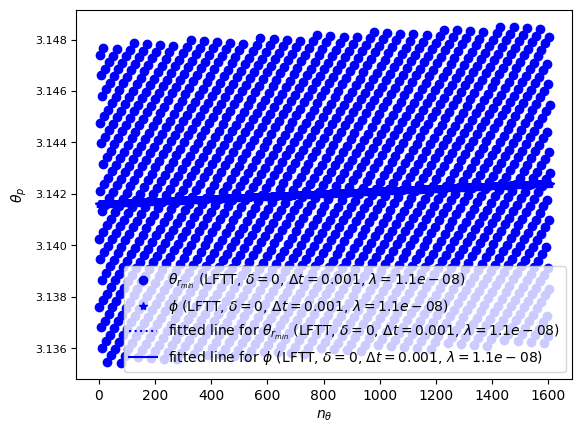

In [92]:
output = Orbit(
    vis=False,vis_prec=True,T_max=1000.1,deltas=[0],lambs=[1.1e-8],methods={"LFTT":0.001},
    r_init=np.array([0.4667, 0.0]), # AU
    v_init=np.array([0.0, 8.198]) # AU/year
)
precession_theta_r_min = output[0]
precession_theta_r_min_regression = output[1]
precession_theta_r_min_regression_R2 = output[2]
precession_phi = output[3]
precession_phi_regression = output[4]
precession_phi_regression_R2 = output[5]
cf = 100*3600*180/np.pi
print("precession using angle at perihelion: ")
for x,y in precession_theta_r_min.items(): print(x," : ",round(cf*y,4), " arc-seconds/century")
print("precession using angle at perihelion with regression: ")
for cond in precession_theta_r_min_regression: 
    print(cond," : ",
    cf*precession_theta_r_min_regression[cond]/0.241,
    "arc-seconds/century | R^2 : ",
    precession_theta_r_min_regression_R2[cond])
print("precession using Rung-Lenz vector direction: ")
for x,y in precession_phi.items(): print(x," : ",round(cf*y,4), " arc-seconds/century")
print("precession using Rung-Lenz vector direction with regression: ")
for cond in precession_phi_regression: 
    print(cond," : ",
    cf*precession_phi_regression[cond]/0.241,
    "arc-seconds/century | R^2 : ",
    precession_phi_regression_R2[cond])
plt.show()

As you can see, now even the $\theta_{r_{max}}$ metric is giving output that is consistent with the known value of 43'' per century.

precession using angle at perihelion: 
(LFTT, $\delta={0}$, $\Delta t=1e-05$, $\lambda=1.1e-08$)  :  493.3639  arc-seconds/century
precession using angle at perihelion with regression: 
(LFTT, $\delta={0}$, $\Delta t=1e-05$, $\lambda=1.1e-08$)  :  117.3805755582181 arc-seconds/century | R^2 :  0.033940286062663194
precession using Rung-Lenz vector direction: 
(LFTT, $\delta={0}$, $\Delta t=1e-05$, $\lambda=1.1e-08$)  :  40.9899  arc-seconds/century
precession using Rung-Lenz vector direction with regression: 
(LFTT, $\delta={0}$, $\Delta t=1e-05$, $\lambda=1.1e-08$)  :  43.02469114242521 arc-seconds/century | R^2 :  0.9999999999319742


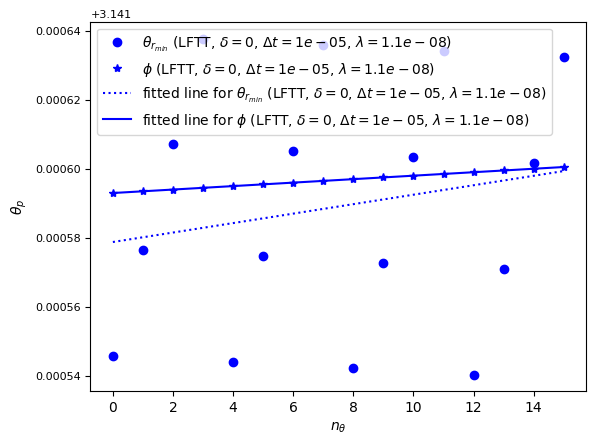

In [94]:
output = Orbit(
    vis=False,vis_prec=True,T_max=10.1,deltas=[0],lambs=[1.1e-8],methods={"LFTT":0.00001},
    r_init=np.array([0.4667, 0.0]), # AU
    v_init=np.array([0.0, 8.198]) # AU/year
)
precession_theta_r_min = output[0]
precession_theta_r_min_regression = output[1]
precession_theta_r_min_regression_R2 = output[2]
precession_phi = output[3]
precession_phi_regression = output[4]
precession_phi_regression_R2 = output[5]
cf = 100*3600*180/np.pi
print("precession using angle at perihelion: ")
for x,y in precession_theta_r_min.items(): print(x," : ",round(cf*y,4), " arc-seconds/century")
print("precession using angle at perihelion with regression: ")
for cond in precession_theta_r_min_regression: 
    print(cond," : ",
    cf*precession_theta_r_min_regression[cond]/0.241,
    "arc-seconds/century | R^2 : ",
    precession_theta_r_min_regression_R2[cond])
print("precession using Rung-Lenz vector direction: ")
for x,y in precession_phi.items(): print(x," : ",round(cf*y,4), " arc-seconds/century")
print("precession using Rung-Lenz vector direction with regression: ")
for cond in precession_phi_regression: 
    print(cond," : ",
    cf*precession_phi_regression[cond]/0.241,
    "arc-seconds/century | R^2 : ",
    precession_phi_regression_R2[cond])
plt.show()

Decreasing $\Delta t$ significantly reduces the deviations in $\theta_{r_{max}}$, making the estimate based on that more accurate. But this effect is not as good as the effect gained on increasing the timespan, when normalised by the computational cost increase. 